# Structural bioinformatic analysis of LiP-MS data  

This notebook provides examples for how to map peptides generated in the LiP-MS workflow to protein structures, and to compute/match different structural descriptors to the identified peptides. A prerequisite for performing the structural analysis is that you have computed a list of peptides and corresponding UniProt IDs. 

The code is written in Python (v3.7), and is dependent on the following libraries (versions used are in brackets): 

- pandas (v1.1.5)
- numpy (v1.19.4)
- Biopython (v1.78)
- seaborn (v0.11)
- matplotlib (v3.3.3)


The script provided should be considered a starting point for your own analysis and may need adaptation dependent on the questions you want to address.

#### Codeauthor: 
Fabian Sesterhenn, PhD <br/>

fabian.sesterhenn@gmail.com 


## 1) Load dependencies and dataset 

In [1]:
import re
import os
import json
import Bio.PDB
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
import gzip

from Bio.Seq import Seq
from Bio import pairwise2

from IPython.display import Javascript, display
import ipywidgets as widgets
pd.set_option("display.max_columns",100)

# Hide warnings
import warnings 
warnings.filterwarnings('ignore')


In [2]:
# Load example dataset 
data = pd.read_csv("./data/LiP_corrected.csv")

In [3]:
# reduce example dataset 
data = data[data["Label"]=="IPTG_1_ vs IPTG_2_"]

In [4]:
# add column containing UniProtID only 
data["UPID"] = data["ProteinName"].apply(lambda x: x.split("_")[0])

In [6]:
data.head()

ProteinName    PeptideSequence              FULL_PEPTIDE  \
0          A5A614_QVAESTPDIPK        QVAESTPDIPK        A5A614_QVAESTPDIPK   
28   P00350_AASEEYNWDLNYGEIAK  AASEEYNWDLNYGEIAK  P00350_AASEEYNWDLNYGEIAK   
56          P00350_AAVLPANLIQ         AAVLPANLIQ         P00350_AAVLPANLIQ   
84        P00350_AAVLPANLIQAQ       AAVLPANLIQAQ       P00350_AAVLPANLIQAQ   
112      P00350_AAVLPANLIQAQR      AAVLPANLIQAQR      P00350_AAVLPANLIQAQR   

                  Label    log2FC        SE    Tvalue         DF    pvalue  \
0    IPTG_1_ vs IPTG_2_  0.818973  0.479762  1.707041  19.859925  0.103402   
28   IPTG_1_ vs IPTG_2_  0.162792  0.236313  0.688882  27.944901  0.496578   
56   IPTG_1_ vs IPTG_2_ -0.434285  0.274801 -1.580362  25.781633  0.126216   
84   IPTG_1_ vs IPTG_2_ -0.674202  0.344293 -1.958220  21.500542  0.063305   
112  IPTG_1_ vs IPTG_2_ -0.611336  1.005592 -0.607936  10.543840  0.556098   

     adj.pvalue  fully_TRI  NSEMI_TRI  CSEMI_TRI  CTERMINUS  StartPos  EndPos  \
0      0.870722      False      False      False        NaN       NaN     NaN   
28     0.978035      False      False      False        NaN       NaN     NaN   
56     0.872957      False      False      False        NaN       NaN     NaN   
84     0.827714      False      False      False        NaN       NaN     NaN   
112    0.980602      False      False      False        NaN       NaN     NaN   

       UPID  
0    A5A614  
28   P00350  
56   P00350  
84   P00350  
112  P00350

## Indicate column names: 

In [7]:
# indicate column names of peptide, UniProtID, and the column containing a pvalue/adjusted pvalue. Make sure you only have proteotypic peptides. 
pep = "PeptideSequence"
UPID = "UPID"
significance = "adj.pvalue"
pvalue_cutoff = 0.05

# Filter dataframe to selected columns
df = data[[UPID,pep,significance]]


# Choose significance threshold for plotting 

df["significant"] = df[significance].apply(lambda x: True if x<pvalue_cutoff else False)


## 2) Load structural descriptors and match them to the peptides of interest

The structural descriptors used here have been computed and published by [Zhao et al., 2021](https://doi.org/10.1093/nar/gkaa931). Structural descriptors for 83 proteomes can be accessed [here](http://biomine.cs.vcu.edu/servers/DESCRIBEPROT/) and are available for download. Here, we provide pre-processed files containing secondary structure predictions (PSIPRED) and disorder predictions (VSL2B) based on the data deposited in DESCRIBEPROT. The provided files are in json format and contain python dictionaries, with keys being UniProt IDs and the values being either sequence, secondary structure prediction or disorder propensity.  

Files are provided for four organisms: 
- human
- mouse
- yeast (S. cerevisiae)
- E.coli 

Here, we are working with an E.coli dataset - so load the descriptors for E.coli: 

In [8]:
w = widgets.Dropdown(
    options=['human', 'Scerevisiae', 'Ecoli',"mouse"],
    disabled=False)
w

Dropdown(options=('human', 'Scerevisiae', 'Ecoli', 'mouse'), value='human')

In [9]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description="Run script")
button.on_click(run_all)
display(button)

Button(description='Run script', style=ButtonStyle())

<IPython.core.display.Javascript object>

In [10]:
path = "./data/"+w.value+"/"

In [11]:
path

'./data/Ecoli/'

In [13]:
# Sequence
with open(path+"UPseq_"+w.value+".json") as fi: 
    seq = json.load(fi)

# Secondary structure prediction
with open(path+"UPPSI_"+w.value+".json") as fi: 
    psi = json.load(fi)

# Disorder prediction
with open(path+"UPID_VSL2B_"+w.value+".json") as fi: 
    diso = json.load(fi)

# 3) Add new columns to dataframe containing predicted secondary structure content and disorder for each peptide

In [15]:
df["SEQ"] = df[UPID].map(seq)
df["PSIPRED"] = df[UPID].map(psi)

In [16]:
df.head(2)

UPID    PeptideSequence  adj.pvalue  significant  \
0   A5A614        QVAESTPDIPK    0.870722        False   
28  P00350  AASEEYNWDLNYGEIAK    0.978035        False   

                                                  SEQ  \
0   MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...   
28  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   

                                              PSIPRED  
0   CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...  
28  CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...

In [17]:
idlist = df[UPID].to_list()
peplist = df[pep].to_list()
seqlist = df["SEQ"].to_list()

## Secondary structure 

In [18]:
def compute_ss_peptide(df,colname_ids = UPID,colname_pepseq=pep,colname_seq = "SEQ",colname_psipred = "PSIPRED"):

    pep_psi = []
    seqs = df[colname_seq].to_list()
    psi = df[colname_psipred].to_list()
    for i,x in enumerate(peplist):
        
        m = re.search(str(x),str(seqs[i]))
        if m:
            if (str(psi[i]) !="NaN" and str(psi[i]) !="nan"):
                ppsi = str(psi[i][m.start():m.end()])
                pep_psi.append(ppsi)
            else:
                pep_psi.append("X")
        else:
            pep_psi.append("X")
    df["peptide_psipred"] = pep_psi
    df["%loop_pep"] = df["peptide_psipred"].apply(lambda x: x.count("C")/len(x))
    df["%helix_pep"] = df["peptide_psipred"].apply(lambda x: x.count("H")/len(x))
    df["%beta_pep"] =df["peptide_psipred"].apply(lambda x: x.count("E")/len(x))
    
    
    return df

In [19]:
df2 = compute_ss_peptide(df)

## Disorder

In [20]:
pep_diso = {}
for i,x in enumerate(peplist):
    m = re.search(str(x),str(seqlist[i]))
    if m: 
        try:
            temp = diso[idlist[i]]
            ppsi = np.mean(temp[m.start():m.end()])
    
        except:
            ppsi = np.nan
    else:
        ppsi = np.nan
    pep_diso.update({peplist[i]:ppsi})

df2["Disorder"] = df2[pep].map(pep_diso)

## Output: Dataframe with secondary structure and disorder content for each peptide

In [21]:
df2

UPID    PeptideSequence  adj.pvalue  significant  \
0       A5A614        QVAESTPDIPK    0.870722        False   
28      P00350  AASEEYNWDLNYGEIAK    0.978035        False   
56      P00350         AAVLPANLIQ    0.872957        False   
84      P00350       AAVLPANLIQAQ    0.827714        False   
112     P00350      AAVLPANLIQAQR    0.980602        False   
...        ...                ...         ...          ...   
709648  Q9JMR6     LLSELAYAGVPFDK         NaN        False   
709676  Q9JMR6            NIIESIR    0.998778        False   
709704  Q9JMR6           NIIESIRK    0.982061        False   
709732  Q9JMR6            NVELDTF         NaN        False   
709757  Q9JMR6         NVELDTFLAR    0.982832        False   

                                                      SEQ  \
0       MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...   
28      MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
56      MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
84      MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
112     MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
...                                                   ...   
709648                                                NaN   
709676                                                NaN   
709704                                                NaN   
709732                                                NaN   
709757                                                NaN   

                                                  PSIPRED    peptide_psipred  \
0       CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...        HHHHHCCCCCC   
28      CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...  HHHHHHCCCCCHHHHHH   
56      CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...         HEECCHHHHH   
84      CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...       HEECCHHHHHHH   
112     CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...      HEECCHHHHHHHH   
...                                                   ...                ...   
709648                                                NaN                  X   
709676                                                NaN                  X   
709704                                                NaN                  X   
709732                                                NaN                  X   
709757                                                NaN                  X   

        %loop_pep  %helix_pep  %beta_pep  Disorder  
0        0.545455    0.454545   0.000000  0.491818  
28       0.294118    0.705882   0.000000  0.239412  
56       0.200000    0.600000   0.200000  0.162000  
84       0.166667    0.666667   0.166667  0.170000  
112      0.153846    0.692308   0.153846  0.174615  
...           ...         ...        ...       ...  
709648   0.000000    0.000000   0.000000       NaN  
709676   0.000000    0.000000   0.000000       NaN  
709704   0.000000    0.000000   0.000000       NaN  
709732   0.000000    0.000000   0.000000       NaN  
709757   0.000000    0.000000   0.000000       NaN  

[24272 rows x 11 columns]

# 4) Add a PDB structure

In [22]:
def convert_df_to_dict(df, key, value):
    '''''
    This function takes as input a dataframe and returns a dictionary of two selected columns. The values are organized as a list.
    '''''
    dic = {k: list(set(g[value].tolist())) for k,g in df.groupby(key)}
    return dic

def retrieve_pdb2(name):
    url = "https://files.rcsb.org/download/"

    cmd = "wget "+url+name

    if not os.path.isfile(name):
        print(cmd)
        os.system(cmd)

def extract_sequence_from_pdb(infile, chain):
    threetoone = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
    pdb = open(infile,"r")
    pdb = pdb.readlines()
    sequence = []
    for line in pdb:
        if line.startswith("ATOM"):
            if line[21:22].strip() == chain:
                if line[13:16].strip() == "CA":
                    sequence.append((threetoone[line[17:20]]))

    return("".join(sequence))

def find_representative_pdb(pep_dict):
    '''''
    identifies a representative pdb structure (one, not several). Needs UPPDB dictionary preloaded. Extracts sequences on-the-fly.
    Input is a pep_dict, generated by: 'pep_dict = convert_df_to_dict(df,"Prot","Pep")'

    returns pep_pdb dictionary that has the peptide and a representative pdb structure that contains this peptide sequence. can be added to original dataframe
    by df["representative_PDB"] = df["Pep"].map(find_representative_pdb(pep_dict))
    '''''

    with open('./data/general/UPID_PDB_CHAIN.json', 'r') as fp:
        UPPDB = json.load(fp)
    pep_pdb_only = {}
    for upid,pep in pep_dict.items():
        count = 0
        try:
            pdb = UPPDB[upid]
        except KeyError:
            continue
        for p in pdb:
            if count < 1:
                p=str(p)
                name = p.split("_")[0]+".pdb"
                chain = p.split("_")[1]
                if not os.path.isfile(name):
                    retrieve_pdb2(name)
                try:
                    ss = extract_sequence_from_pdb(name,chain)
                except FileNotFoundError:
                    continue
                if ss:
                    for pe in pep:
                        if pe in ss:
                            count = 1
                            pep_pdb_only.update({pe:p})

            else:
                continue
    return pep_pdb_only

###### A new dataframe is created here with only 300 entries, to reduce runtime in this example. Needs to be adjusted if you want to run it for your entire dataset. 

In [23]:
# Executing this can take a while depending on the size of the dataframe and the number of PDB structures, as PDB structures are downloaded and then a new column is added to the dataframe with a representative PDB structure.
# Consider to reduce the size of your dataframe to only the necessary entries before starting to download. 
df3 = df2.head(300)
pep_dict = convert_df_to_dict(df3,UPID,pep)
df3["representative_PDB"] = df[pep].map(find_representative_pdb(pep_dict))

In [24]:
set(df3[UPID].to_list())

{'A5A614',
 'P00350',
 'P00363',
 'P00370',
 'P00393',
 'P00448',
 'P00452',
 'P00490',
 'P00509',
 'P00547'}

In [25]:
df3.head()

UPID    PeptideSequence  adj.pvalue  significant  \
0    A5A614        QVAESTPDIPK    0.870722        False   
28   P00350  AASEEYNWDLNYGEIAK    0.978035        False   
56   P00350         AAVLPANLIQ    0.872957        False   
84   P00350       AAVLPANLIQAQ    0.827714        False   
112  P00350      AAVLPANLIQAQR    0.980602        False   

                                                   SEQ  \
0    MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...   
28   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
56   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
84   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
112  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   

                                               PSIPRED    peptide_psipred  \
0    CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...        HHHHHCCCCCC   
28   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...  HHHHHHCCCCCHHHHHH   
56   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...         HEECCHHHHH   
84   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...       HEECCHHHHHHH   
112  CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...      HEECCHHHHHHHH   

     %loop_pep  %helix_pep  %beta_pep  Disorder representative_PDB  
0     0.545455    0.454545   0.000000  0.491818                NaN  
28    0.294118    0.705882   0.000000  0.239412             2ZYA_B  
56    0.200000    0.600000   0.200000  0.162000             2ZYA_B  
84    0.166667    0.666667   0.166667  0.170000             2ZYA_B  
112   0.153846    0.692308   0.153846  0.174615             2ZYA_B

# 5) Create a list of commands to load in PyMol and visualize the identified peptides

Load dependencies

In [26]:
with open("./data/general/UPID_PDB_CHAIN.json") as fi: 
    UPPDB = json.load(fi)
with gzip.open("./data/general/PDB_CHAIN_SEQ.json.gz") as fi: 
    PDBseqs = json.load(fi)

Activate function to retrieve PDB files in pymol and color peptides according to significance

In [27]:
def get_PDBs_highlight_peptides(df=df,colname_ids = UPID,colname_pepseq=pep,colname_pvalue = significance,fetchall=False,maxlim=5,significance_cutoff=0.05):

    '''''
    input is a dataframe, the name of the column with the UniProtIDs, the peptide sequence and a column containing pvalues. Significance cutoff is 0.05 by default, and peptides with a smaller pval are colored red, all others black. 
    The fetchall option allows to retrieve all PDBs, even if the peptide of interest is not contained in the PDB structure (default=False)
    Maxlim is set to 5 by default, so that a maximum of 5 PDB structures are retrieved for each uniprot entry. 
    
    The dataframe will initially be sorted in descending order according to the significance peptide column. 
    This ensures that peptides that are significant will be colored last, and thus will not be overwritten by the color of an overlapping non-significant peptide. 
    
    The output is a file to copy/paste in pymol, containing the commands to retrieve pdb files,
    group them and highlight the peptides by color.
    This function relies on  the find_seq.py script for finding and highlighting the peptide sequence.

    '''''
    
    df = df.sort_values(by=colname_pvalue,ascending=False)
    
    query = convert_df_to_dict(df,colname_ids,colname_pepseq)

    pep_pval = convert_df_to_dict(df,colname_pepseq,colname_pvalue)
    
    log = open("error.log","w")
    output = open("pymol_commands.txt","w")
    output.write("run findseq.py"+"\n")
    output.write("bg_color white" +"\n")
    for s in query.keys():
        pdb = []
        pdb3 = []
        try:
            pdb.append(UPPDB[s])
        except KeyError:
            e1 = "no corresponding PDB for "+s
            log.write(e1+"\n")
            continue
        pdb2 = [val for sublist in pdb for val in sublist]
        if len(pdb2) == 0:
                print("length 0")
                continue
        else:
            for i,p in enumerate(pdb2[:maxlim]):
                try:
                    p = p.strip()
                    seq = PDBseqs[str(p)]
                except KeyError:
                    try:
                        pdbid = pdb2[i].split("_")[0]
                        pdbchain = pdb2[i].split("_")[1]
                        seq = extract_sequence_from_pdb(pdbid,pdbchain)
                    except:
                        continue
                command1 = "fetch " + p
                command2 = "color lightblue, " +p

                for x in query[s]:
                    pdbid = pdb2[i].split("_")[0]
                    pdbchain = pdb2[i].split("_")[1]
                    if str(x) in str(seq):
                            start = str(seq).index(x)-1
                            length = len(x)
                            end = start + length
                            

                            if pep_pval[x][0] < significance_cutoff:
                                color = "red"
                            else: 
                                color = "black"

                            find = "findseq "+x+", "+p+", "+p+"_"+x
                            coloring  = "color " +color+", "+p+"_"+x
                            pdb3.append(p)
                            print(command1+"\n")
                            print(find)
                            print(coloring+"\n")
                            print("delete "+p+"_"+x+"\n")
                            output.write(command1+"\n")
                            output.write(find+"\n"+coloring+"\n")
                            output.write("delete "+p+"_"+x+"\n")
                    else:
                            e2 = x+ " could not be found in "+pdbid
                            log.write(e2+"\n")
                            if fetchall:
                                output.write(command1+"\n")
        if fetchall:
            output.write("group "+ s+","+(" ".join(x for x in pdb2))+"\n")
            print("group "+ s+","+(" ".join(x for x in pdb2)))
        else:
            if len(pdb3)==0:
                continue
            else:
                output.write("group "+ s+","+(" ".join(x for x in pdb3))+"\n")
                print("group "+ s+","+(" ".join(x for x in pdb3)))
    log.close()
    output.close()
    return log, output

#### Call function and copy output in PyMol. Instead of copying, you can also use "run pymol_scripts/execute_commands.py". This script will execute the commands written in the file "pymol_commands.txt" line by line. 

In [91]:
get_PDBs_highlight_peptides(df3,UPID,pep,significance)

fetch 2ZYA_B

findseq KLVPYYTVK, 2ZYA_B, 2ZYA_B_KLVPYYTVK
color black, 2ZYA_B_KLVPYYTVK

delete 2ZYA_B_KLVPYYTVK

fetch 2ZYA_B

findseq LIAEAYSLLK, 2ZYA_B, 2ZYA_B_LIAEAYSLLK
color black, 2ZYA_B_LIAEAYSLLK

delete 2ZYA_B_LIAEAYSLLK

fetch 2ZYA_B

findseq NRELSAEGFNFIGTGVSGGEEGALK, 2ZYA_B, 2ZYA_B_NRELSAEGFNFIGTGVSGGEEGALK
color black, 2ZYA_B_NRELSAEGFNFIGTGVSGGEEGALK

delete 2ZYA_B_NRELSAEGFNFIGTGVSGGEEGALK

fetch 2ZYA_B

findseq SYLIDITK, 2ZYA_B, 2ZYA_B_SYLIDITK
color black, 2ZYA_B_SYLIDITK

delete 2ZYA_B_SYLIDITK

fetch 2ZYA_B

findseq GDIIIDGGNTFFQDTIRR, 2ZYA_B, 2ZYA_B_GDIIIDGGNTFFQDTIRR
color black, 2ZYA_B_GDIIIDGGNTFFQDTIRR

delete 2ZYA_B_GDIIIDGGNTFFQDTIRR

fetch 2ZYA_B

findseq IVSYAQGFSQLR, 2ZYA_B, 2ZYA_B_IVSYAQGFSQLR
color black, 2ZYA_B_IVSYAQGFSQLR

delete 2ZYA_B_IVSYAQGFSQLR

fetch 2ZYA_B

findseq NNGELSSYLIDITK, 2ZYA_B, 2ZYA_B_NNGELSSYLIDITK
color black, 2ZYA_B_NNGELSSYLIDITK

delete 2ZYA_B_NNGELSSYLIDITK

fetch 2ZYA_B

findseq AGAGTDAAIDSLKPYLDKG, 2ZYA_B, 2ZYA_B_AGAGTDAAIDSL

fetch 4BHT_B

findseq PAGDIGVGGR, 4BHT_B, 4BHT_B_PAGDIGVGGR
color black, 4BHT_B_PAGDIGVGGR

delete 4BHT_B_PAGDIGVGGR

fetch 3SBO_B

findseq PNQTEFAQAVR, 3SBO_B, 3SBO_B_PNQTEFAQAVR
color black, 3SBO_B_PNQTEFAQAVR

delete 3SBO_B_PNQTEFAQAVR

fetch 3SBO_B

findseq GSGNVAQYAIEK, 3SBO_B, 3SBO_B_GSGNVAQYAIEK
color black, 3SBO_B_GSGNVAQYAIEK

delete 3SBO_B_GSGNVAQYAIEK

fetch 3SBO_B

findseq TTLWPFLEQNPK, 3SBO_B, 3SBO_B_TTLWPFLEQNPK
color black, 3SBO_B_TTLWPFLEQNPK

delete 3SBO_B_TTLWPFLEQNPK

fetch 3SBO_B

findseq VQFSSAIGPYKG, 3SBO_B, 3SBO_B_VQFSSAIGPYKG
color black, 3SBO_B_VQFSSAIGPYKG

delete 3SBO_B_VQFSSAIGPYKG

fetch 3SBO_B

findseq TSGLEMAQNAAR, 3SBO_B, 3SBO_B_TSGLEMAQNAAR
color black, 3SBO_B_TSGLEMAQNAAR

delete 3SBO_B_TSGLEMAQNAAR

fetch 3SBO_B

findseq GVLFAPGK, 3SBO_B, 3SBO_B_GVLFAPGK
color black, 3SBO_B_GVLFAPGK

delete 3SBO_B_GVLFAPGK

fetch 3SBO_B

findseq NIAGFVK, 3SBO_B, 3SBO_B_NIAGFVK
color black, 3SBO_B_NIAGFVK

delete 3SBO_B_NIAGFVK

fetch 3SBO_B

findseq EFGLVYLE, 3SBO_B, 

findseq TNYDPSRFPSGK, 3R1R_B, 3R1R_B_TNYDPSRFPSGK
color black, 3R1R_B_TNYDPSRFPSGK

delete 3R1R_B_TNYDPSRFPSGK

fetch 3R1R_B

findseq LAIFHLR, 3R1R_B, 3R1R_B_LAIFHLR
color black, 3R1R_B_LAIFHLR

delete 3R1R_B_LAIFHLR

fetch 3R1R_B

findseq GILPIDTYK, 3R1R_B, 3R1R_B_GILPIDTYK
color black, 3R1R_B_GILPIDTYK

delete 3R1R_B_GILPIDTYK

fetch 3R1R_B

findseq AAADLISR, 3R1R_B, 3R1R_B_AAADLISR
color black, 3R1R_B_AAADLISR

delete 3R1R_B_AAADLISR

fetch 3R1R_B

findseq GILPIDTYKK, 3R1R_B, 3R1R_B_GILPIDTYKK
color black, 3R1R_B_GILPIDTYKK

delete 3R1R_B_GILPIDTYKK

fetch 3R1R_B

findseq SPFDPAIAPVR, 3R1R_B, 3R1R_B_SPFDPAIAPVR
color black, 3R1R_B_SPFDPAIAPVR

delete 3R1R_B_SPFDPAIAPVR

fetch 3R1R_B

findseq TFEAIQYYLLK, 3R1R_B, 3R1R_B_TFEAIQYYLLK
color black, 3R1R_B_TFEAIQYYLLK

delete 3R1R_B_TFEAIQYYLLK

fetch 3R1R_B

findseq FEPPALYDHVVK, 3R1R_B, 3R1R_B_FEPPALYDHVVK
color black, 3R1R_B_FEPPALYDHVVK

delete 3R1R_B_FEPPALYDHVVK

fetch 3R1R_B

findseq VLDWAAEGLHNVSISQVELR, 3R1R_B, 3R1R_B_VLDWAAEGLHN

delete 1AHX_A_DSETVDR

fetch 1AHX_A

findseq TQELLFGK, 1AHX_A, 1AHX_A_TQELLFGK
color black, 1AHX_A_TQELLFGK

delete 1AHX_A_TQELLFGK

fetch 1AHX_A

findseq FSFSGLTK, 1AHX_A, 1AHX_A_FSFSGLTK
color black, 1AHX_A_FSFSGLTK

delete 1AHX_A_FSFSGLTK

fetch 1AHX_A

findseq LVAADSETVDR, 1AHX_A, 1AHX_A_LVAADSETVDR
color black, 1AHX_A_LVAADSETVDR

delete 1AHX_A_LVAADSETVDR

fetch 1AHX_A

findseq GLEEDAEGLR, 1AHX_A, 1AHX_A_GLEEDAEGLR
color black, 1AHX_A_GLEEDAEGLR

delete 1AHX_A_GLEEDAEGLR

fetch 1AHX_A

findseq VWVSNPSWPNHK, 1AHX_A, 1AHX_A_VWVSNPSWPNHK
color black, 1AHX_A_VWVSNPSWPNHK

delete 1AHX_A_VWVSNPSWPNHK

fetch 1AHX_A

findseq ELIVASSYSK, 1AHX_A, 1AHX_A_ELIVASSYSK
color black, 1AHX_A_ELIVASSYSK

delete 1AHX_A_ELIVASSYSK

fetch 1AHX_A

findseq SVFNSAGLEVR, 1AHX_A, 1AHX_A_SVFNSAGLEVR
color black, 1AHX_A_SVFNSAGLEVR

delete 1AHX_A_SVFNSAGLEVR

fetch 1AHX_A

findseq ILSNDALR, 1AHX_A, 1AHX_A_ILSNDALR
color black, 1AHX_A_ILSNDALR

delete 1AHX_A_ILSNDALR

fetch 1AHX_A

findseq QLFVNTLQEKG, 1AHX_A

(<_io.TextIOWrapper name='error.log' mode='w' encoding='UTF-8'>,
 <_io.TextIOWrapper name='pymol_commands.txt' mode='w' encoding='UTF-8'>)

### Alternative: Color peptides according to significance in a selected pair of UniProtID and PDB 

In [63]:
def color_peptides_in_selected_PDB(df,UPID,PDB,colname_ids, colname_pepseq, colname_pvalue ="significance", significance_cutoff=0.05):
    
    '''''
    Function to color peptides in a selected pair of UniProtID and PDB structure. Input is your dataframe that will be filtered according to the UniProt entry, 
    and sorted by the column indicating significance. 
    All peptides for this uniprot ID will be searched in the PDB you indicate (format: PDBCODE_CHAIN).
    The PDB will be loaded into pymol, colored in lightblue by default, and then peptides below the significance cutoff (to be specified, default 0.05) will be colored red, all other detected peptides are black. 
    Output is a file called "pymol_commands.txt" in the same working directory, that can be copied to pymol. Requires the findseq.py script. 
        
    '''''
    
    df2 = df[df[colname_ids]==UPID].sort_values(by=colname_pvalue,ascending=False)
    
    peps = df2[colname_pepseq].to_list()
    
    pep_pval = convert_df_to_dict(df2,colname_pepseq,colname_pvalue)
    
    pdb_name = PDB.split("_")[0]
    pdb_name2 = PDB.split("_")[0]+".pdb"
    pdb_chain = PDB.split("_")[1]

    output = open("pymol_commands.txt","w")
    output.write("run findseq.py"+"\n")
    output.write("bg_color white" +"\n")
    output.write("fetch " + pdb_name +"\n")
    output.write("color lightblue, "+pdb_name+"\n")
    
    
    for ind,p in enumerate(peps): 
        if pep_pval[p][0] < significance_cutoff:

            output.write("findseq "+p+", "+pdb_name+", seq_"+p+"\n")
            output.write("color red, "+"seq_"+p+"\n")
            output.write("delete "+"seq_"+p+"\n")
        else:
            output.write("findseq "+p+", "+pdb_name+", seq_"+p+"\n")
            output.write("color black, "+"seq_"+p+"\n")
            output.write("delete "+"seq_"+p+"\n")
            
    output.close()
    return output

In [71]:
df3.columns

Index(['UPID', 'PeptideSequence', 'adj.pvalue', 'significant', 'SEQ',
       'PSIPRED', 'peptide_psipred', '%loop_pep', '%helix_pep', '%beta_pep',
       'Disorder', 'representative_PDB', 'distance_act_site',
       'distance_bind_site', 'distance_ca_binding',
       'distance_nucleotide_binding', 'distance_metal_binding'],
      dtype='object')

Call function. Output file will be written to your working directory and can be copied into PyMol to load the PDB and highlight all peptides. 

In [75]:
color_peptides_in_selected_PDB(df3,"P00350","2ZYA_B",UPID,pep,significance)

<_io.TextIOWrapper name='pymol_commands.txt' mode='w' encoding='UTF-8'>

# 6) Measure distances to known functional sites 

load dependencies - functional site annotations from UniProt (December 2020)

In [32]:
with open(path+w.value+'_bind_sites.json', 'r') as fp:
    bindingsites = json.load(fp)
with open(path+w.value+'_active_sites.json', 'r') as fp:
    activesites = json.load(fp)
with open(path+w.value+'_nucleotide_binding.json', 'r') as fp:
    nucleotidebinding = json.load(fp)
with open(path+w.value+'_metal_binding.json', 'r') as fp:
    metalbinding = json.load(fp)
with open(path+w.value+'_calcium_binding.json', 'r') as fp:
    calciumbinding = json.load(fp)

In [76]:
pep_dict = convert_df_to_dict(df3,UPID,pep)

In [77]:
data_representative_pdb = find_representative_pdb(pep_dict)

In [79]:
def append_value(dict_obj, key, value):
    '''''
    This function is useful for creating a dictionary where new values can be added and do not replace the value if the key was already in the dict.
    Use instead of dict.update()
    USAGE: append_value(dict,key,value). Can also be as dict inside a dict: append_value(pep_coord,k,{x:pep_coordinates})

    '''''
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value
    return
        
        
def extract_coords(infile, chain):
    '''''
    Extracts Calpha coordinates from a PDB file. 
    Input: PDB and chain identifier. 
    
    '''''
    
    
    threetoone = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb = open(infile,"r")
    chain = chain
    pdb = pdb.readlines()
    sequence = []
    coords = []

    output = {}
    for line in pdb:
        if line.startswith("ATOM"):
            if line[21:22].strip() == chain:
                if line[13:16].strip() == "CA":
                    sequence.append((threetoone[line[17:20]]))
                    xcoords=float(line[30:38].strip())
                    ycoords=float(line[39:46].strip())
                    zcoords=float(line[47:54].strip())
                    ar = np.array([xcoords,ycoords,zcoords])
                    coords.append(ar)
    seq = "".join(sequence)
    return coords

In [80]:
def extract_coordinates_peptides(pep_dict,seq=seq,data_representative_pdb=data_representative_pdb):
    '''''
    Input: dictionary with the UniProtID:[peptides]. 
    Requirements: 
    1) load UniProtID:sequence dictionary ("seq"). 
    2) Create dictionary with peptide:PDB from your dataframe ("data_representative_pdb")
    Output: dictionary containing the peptides with their coordinates as np.array (pep_coord)
    
    '''''
    pep_coord = {}
    for k, v in pep_dict.items():
        
        temp_dict = {}
        
        for x in v: 
            try:
                m = re.search(x,seq[k])
                pdb = data_representative_pdb[x]
    
                name = pdb.split("_")[0]+".pdb"
                chain = pdb.split("_")[1]

                if not os.path.isfile(name):
                    retrieve_pdb2(name)

                s  = extract_sequence_from_pdb(name,chain)


                o = re.search(x,s)
                xx = extract_coords(name,chain)
                pep_coordinates = xx[o.start():o.end()]
                temp_dict.update({x:pep_coordinates})
                pep_coord.update({k:temp_dict})
                #append_value(pep_coord,k,{x:pep_coordinates})

            except KeyError:
                continue
    return pep_coord

In [81]:
p = extract_coordinates_peptides(pep_dict)

In [92]:
df3.head()

UPID    PeptideSequence  adj.pvalue  significant  \
0    A5A614        QVAESTPDIPK    0.870722        False   
28   P00350  AASEEYNWDLNYGEIAK    0.978035        False   
56   P00350         AAVLPANLIQ    0.872957        False   
84   P00350       AAVLPANLIQAQ    0.827714        False   
112  P00350      AAVLPANLIQAQR    0.980602        False   

                                                   SEQ  \
0    MSEFDAQRVAERIDIVLDILVAGDYHSAIHNLEILKAELLRQVAES...   
28   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
56   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
84   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
112  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   

                                               PSIPRED    peptide_psipred  \
0    CCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHH...        HHHHHCCCCCC   
28   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...  HHHHHHCCCCCHHHHHH   
56   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...         HEECCHHHHH   
84   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...       HEECCHHHHHHH   
112  CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...      HEECCHHHHHHHH   

     %loop_pep  %helix_pep  %beta_pep  Disorder representative_PDB  \
0     0.545455    0.454545   0.000000  0.491818                NaN   
28    0.294118    0.705882   0.000000  0.239412             2ZYA_B   
56    0.200000    0.600000   0.200000  0.162000             2ZYA_B   
84    0.166667    0.666667   0.166667  0.170000             2ZYA_B   
112   0.153846    0.692308   0.153846  0.174615             2ZYA_B   

     distance_act_site  distance_bind_site  distance_ca_binding  \
0                  NaN                 NaN                  NaN   
28           10.123902           16.948891                  NaN   
56           27.908916            5.142416                  NaN   
84           27.908916            3.818236                  NaN   
112          27.908916            0.000000                  NaN   

     distance_nucleotide_binding  distance_metal_binding  
0                            NaN                     NaN  
28                     21.167085                     NaN  
56                     39.906635                     NaN  
84                     39.906635                     NaN  
112                    39.906635                     NaN

In [83]:
def compute_distance_to_func_site(functionalsites,df,pep_coord,colname_pep ="PeptideSequence"):
    
    '''''
    input: 
    functionalsites = dictionary with uniprot ids and a list of residues annotated as functional site (e.g. binding, active site)
    df = your dataframe  
    pep_coord = output from extract_coordinates_peptides() function
    colname_pep = name of the column that contains the peptide sequence
    
    output: 
    dictionary with peptide:minimal Calpha distance to a functionalsite (minimal distance to the closest functional site only!)
    
    '''''
       
    # 1) Create artificial peptides around the functional site (+/-3 residues) 
    
    active_site_peptides = {}
    for k,v in functionalsites.items():
        if str(v) == 'nan':
            continue
        else: 
            try: 
                seqs = seq[k]
            except KeyError:
                continue
            pept = []
            for x in v: 
                pept.append(seqs[x-3:x+3])
                active_site_peptides.update({k:pept})
    
    # 2) Extract coordinates from PDB for the functional site of interest
    
    active_site_coord = {}
    Pep_representative_PDB = convert_df_to_dict(df,colname_pep,"representative_PDB")
    for kk, v in active_site_peptides.items():
        try:
            for k in pep_dict[kk]:
                representative_pdb = Pep_representative_PDB[k][0]

                if str(representative_pdb) =="nan":
                    continue
                else:
                    name = representative_pdb.split("_")[0]+".pdb"
                    chain = representative_pdb.split("_")[1]
                    s  = extract_sequence_from_pdb(name,chain)

                    for x in v: 
                        try:
                            match = re.search(x,s)
                            match2 =  match.start()+2
                            
                            xx = extract_coords(name,chain)
                            pep_coordinates = xx[match2]
            
                            append_value(active_site_coord,kk,pep_coordinates)

                        except:
                            continue
        except KeyError:
            continue
        
    # 3) Compute minimal distance
    
    pep_min_dist_to_active_site = {}
    for k,v in pep_coord.items():

        try:
            active = active_site_coord[k]
        except:
            continue
        if str(active) == "nan":
            continue
        else:
            for kk,vv in v.items():

                temp_active = []
                for vvv in vv:

                    for a in active:
                        dist = np.linalg.norm(vvv-a)
                        temp_active.append(dist)
                    
                pep_min_dist_to_active_site.update({kk:min(temp_active)})
                
    
    return pep_min_dist_to_active_site


##### compute distance to active sites, binding sites etc and add to the dataframe df3

In [84]:
act_dist = compute_distance_to_func_site(activesites,df3,p)

In [85]:
bind_dist = compute_distance_to_func_site(bindingsites,df3,p)

In [86]:
ca_dist = compute_distance_to_func_site(calciumbinding,df3,p)
nucleotide_dist = compute_distance_to_func_site(nucleotidebinding,df3,p)
metal_dist = compute_distance_to_func_site(metalbinding,df3,p)

In [87]:
df3["distance_act_site"] = df3[pep].map(act_dist)
df3["distance_bind_site"] = df3[pep].map(bind_dist)
df3["distance_ca_binding"] = df3[pep].map(ca_dist)
df3["distance_nucleotide_binding"] = df3[pep].map(nucleotide_dist)
df3["distance_metal_binding"] = df3[pep].map(metal_dist)

In [88]:
df3[df3["representative_PDB"].notnull()].head(30)

UPID          PeptideSequence  adj.pvalue  significant  \
28   P00350        AASEEYNWDLNYGEIAK    0.978035        False   
56   P00350               AAVLPANLIQ    0.872957        False   
84   P00350             AAVLPANLIQAQ    0.827714        False   
112  P00350            AAVLPANLIQAQR    0.980602        False   
140  P00350            AGAGTDAAIDSLK    0.993225        False   
168  P00350       AGAGTDAAIDSLKPYLDK    0.979342        False   
196  P00350      AGAGTDAAIDSLKPYLDKG    0.975408        False   
224  P00350                 AQGFSQLR    0.832530        False   
252  P00350       DEDGNYLVDVILDEAANK         NaN        False   
279  P00350                 DYFGAHTY    0.999816        False   
307  P00350                DYFGAHTYK    0.976366        False   
360  P00350             EAYELVAPILTK    0.995587        False   
388  P00350               EFVESLETPR    0.961667        False   
416  P00350              EFVESLETPRR    0.974526        False   
444  P00350                  EGVFHTE    0.999816        False   
500  P00350            EKTEEVIAENPGK    0.981853        False   
528  P00350           EKTEEVIAENPGKK    0.982832        False   
556  P00350  ELSAEGFNFIGTGVSGGEEGALK    0.999240        False   
584  P00350        GAGTDAAIDSLKPYLDK         NaN        False   
612  P00350        GDIIIDGGNTFFQDTIR         NaN        False   
630  P00350       GDIIIDGGNTFFQDTIRR    0.999263        False   
658  P00350       GFNFIGTGVSGGEEGALK    0.996999        False   
686  P00350           GGLNLTNEELAQTF    0.997735        False   
714  P00350               GPSIMPGGQK    0.999816        False   
742  P00350              GVSGGEEGALK    0.974345        False   
770  P00350                GYTVSIFNR    0.998484        False   
798  P00350              IGADGAGHYVK    0.860040        False   
854  P00350                 IVSYAQGF    0.984565        False   
882  P00350             IVSYAQGFSQLR    0.986359        False   
910  P00350      KDEDGNYLVDVILDEAANK    0.958725        False   

                                                   SEQ  \
28   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
56   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
84   MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
112  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
140  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
168  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
196  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
224  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
252  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
279  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
307  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
360  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
388  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
416  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
444  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
500  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
528  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
556  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
584  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
612  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
630  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
658  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
686  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
714  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
742  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
770  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
798  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
854  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
882  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   
910  MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...   

                                               PSIPRED  \
28   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...   
56   CCHHHCEEEEEEEECCCEEEEEECCCEEEEEEECCHHHCHHHHCCC...   
84   CCHHHCEEEEEEE

UniProt entry P00350 (6-phosphogluconate dehydrogenase, decarboxylating) is an illustrative example with many peptides detected, an available PDB structure, and for which active sites, binding sites and nucleotide binding sites are annotated in UniProt. Distances for each peptide to the closest functional site are computed (see above). 

In [89]:
bindingsites["P00350"]

[102, 102, 191, 260, 287, 445, 451]

In [90]:
activesites["P00350"]

[183, 190]

In [62]:
nucleotidebinding["P00350"]

[10, 11, 12, 13, 14, 15, 33, 34, 35, 74, 75, 76]

## Compute distances manually between selected peptides or peptide/ligand

In [49]:
def extract_HETATM_ID(infile,chain):
    '''''
    This function is able to get the HETATM (except water) ID from a PDB file. It returns a dictionary with the format PDB:[NAMES OF LIGANDS].
    Input: a PDB file and the chain name. 
    Example: extract_HETATM_ID("PATH/TO/FILE/6xvf.pdb","A")
    '''''

    i = open(infile,"r")
    i = i.readlines()
    ligands = []
    ligands2 = []
    PDBLIG={}
    for line in i:
        if line.startswith("HETATM"):
            if line[17:20] != "HOH":
                ligand = line[17:20]
                ligands.append(ligand)
    ligands2 = list(set(ligands))
    PDBLIG[infile.strip("_HETATM.pdb")] = ligands2
    return PDBLIG

In [50]:
def compute_distance(PDB1, chain1, pep1, PDB2, chain2, pep2,mode="CA"):
    
    '''''
    Function to compute the distance between two peptides in either the same or different PDB files.
    Example: compute_distance("/PATH/TO/FILE/4jhw.pdb","CHAIN","PEPTIDEK","/PATH/TO/FILE/4jhw.pdb","CHAIN","PEPTIDEK",mode="CA")
    currently only works in Calpha mode. Measuring distances between all atoms will be added later. 
    
    '''''
        
    i1 = open(PDB1,"r").readlines()
    i2 = open(PDB2,"r").readlines()
    coords_pep1 = []
    coords_pep2 = []
    distances = []
    i1_seq = extract_sequence_from_pdb(PDB1, chain1)
    i2_seq = extract_sequence_from_pdb(PDB2, chain2)
    
    i1_list = []
    i2_list = []
    
    
    match1 = re.search(pep1,i1_seq)
    if match1 is None:
        raise Exception("peptide sequence "+pep1 + " was not found in "+PDB1) 
        
    
    match2 = re.search(pep2,i2_seq)
    if match2 is None:
        raise Exception("peptide sequence "+pep2 + " was not found in "+PDB2) 
    
    
    if mode=="CA":

        for line in i1: 
            if line.startswith("ATOM"):
                if line[21:22].strip() == chain1:
                    if line[13:16].strip() == "CA":
                        i1_list.append(line)
       
        for x in i1_list[match1.start():match1.end()]:

            x_coord = float(x[31:38].strip())
            y_coord = float(x[39:46].strip())
            z_coord = float(x[47:54].strip())
            ar = np.array([x_coord,y_coord,z_coord])
            coords_pep1.append(ar)


        for line in i2: 
            if line.startswith("ATOM"):
                if line[21:22].strip() == chain2:
                    if line[13:16].strip() == "CA":
                        i2_list.append(line)

        for x in i2_list[match2.start():match2.end()]:

            x_coord = float(x[31:38].strip())
            y_coord = float(x[39:46].strip())
            z_coord = float(x[47:54].strip())
            ar = np.array([x_coord,y_coord,z_coord])
            coords_pep2.append(ar)

        for c in coords_pep1:
            for c2 in coords_pep2:
                dist = np.linalg.norm(c-c2)
                distances.append(dist)
   
                
    print("Minmal distance is: "+str(min(distances))+" Å")
    
    #return min(distances)    

In [51]:
def compute_distance_HETATM(PDB1, chain1, pep1, PDB2, HETATM):
    
    '''''
    Function to compute the distance between a peptide and a ligand/HETATM. 
    Example: compute_distance("/PATH/TO/FILE/4jhw.pdb","CHAIN","PEPTIDEK","/PATH/TO/FILE/4jhw.pdb","LIGAND_ID")
    You can look up the ID of the ligand by calling the function "extract_HETATM_ID(PDBFILE,CHAIN)".
    '''''
        
    i1 = open(PDB1,"r").readlines()
    i2 = open(PDB2,"r").readlines()
    coords_pep1 = []
    coords_pep2 = []
    distances = []
    i1_seq = extract_sequence_from_pdb(PDB1, chain1)
    match1 = re.search(pep1,i1_seq)
    i1_list = []
    i2_list = []
    
    if match1 is None:
        raise Exception("peptide sequence "+pep1 + " was not found in "+PDB1) 


    for line in i1: 
        if line.startswith("ATOM"):
            if line[21:22].strip() == chain1:
                if line[13:16].strip() == "CA":
                    i1_list.append(line)

    for x in i1_list[match1.start():match1.end()]:

        x_coord = float(x[31:38].strip())
        y_coord = float(x[39:46].strip())
        z_coord = float(x[47:54].strip())
        ar = np.array([x_coord,y_coord,z_coord])
        coords_pep1.append(ar)


    for line in i2: 
        if line.startswith("HETATM"):
           
                if line[17:20].strip() == HETATM:
                        i2_list.append(line)

    for x in i2_list:

        x_coord = float(x[31:38].strip())
        y_coord = float(x[39:46].strip())
        z_coord = float(x[47:54].strip())
        ar = np.array([x_coord,y_coord,z_coord])
        coords_pep2.append(ar)

    for c in coords_pep1:
        for c2 in coords_pep2:
            dist = np.linalg.norm(c-c2)
            distances.append(dist)
   
                
    print("Minmal distance to ligand is: " + str(min(distances))+ " Å")
    
    #return min(distances) 

### Examples 

##### Distance between two peptides

In [52]:
compute_distance("./data/1FKL.pdb","A","GKQEVIR","./data/1FKL.pdb","A","KFDSSRDR",mode="CA")

Minmal distance is: 14.682309831903153 Å


##### Get ID of the bound ligands and compute distance between the ligand and a peptide

In [53]:
extract_HETATM_ID("./data/1FKL.pdb","A")

{'/data/1FKL': ['RAP']}

In [54]:
compute_distance_HETATM("./data/1FKL.pdb","A","GKQEVIR","./data/1FKL.pdb","RAP")

Minmal distance to ligand is: 3.2612485339207136 Å


# 7) Plotting structural parameters

<Figure size 432x288 with 0 Axes>

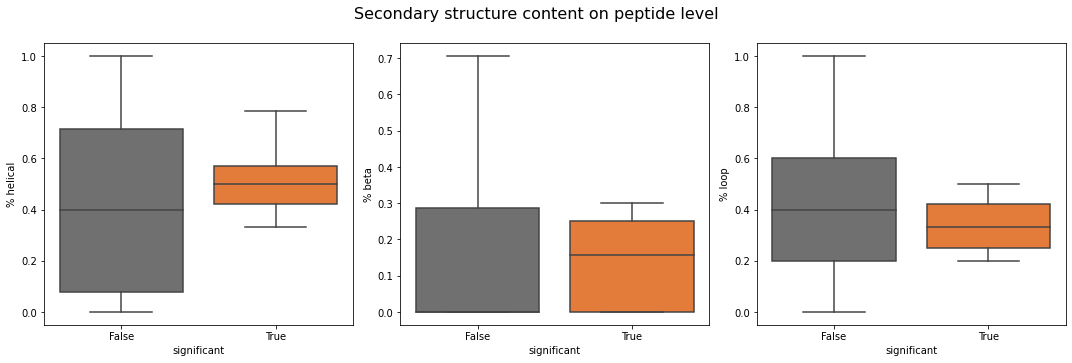

In [56]:
fig = plt.figure()
fig, ([ax1, ax2,ax3]) = plt.subplots(1,3,figsize=(15,5))

fig.suptitle(("Secondary structure content on peptide level"), y=1,fontsize=16)

sns.boxplot(y="%helix_pep", x="significant", data=df, palette=["#707070","#FF741F"],ax = ax1,showfliers=False).set_ylabel("% helical")
sns.boxplot(y="%beta_pep", x="significant", data=df, palette=["#707070","#FF741F"],ax = ax2,showfliers=False).set_ylabel("% beta")
sns.boxplot(y="%loop_pep", x="significant", data=df, palette=["#707070","#FF741F"],ax = ax3,showfliers=False).set_ylabel("% loop")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['svg.fonttype'] = 'none'

plt.tight_layout()